In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.style.use("seaborn")

In [3]:
#Downloading info
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info'
url_file = requests.get(url)
with open("covtype.info","wb") as file:
    file.write(url_file.content)  

### Loading Data set

In [4]:
#Loading data set
df_trees = pd.read_csv("covtype.csv")
df_trees.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5


In [5]:
# The columns Soil_Typex are redundant, aren't they?
soils = []
for i in range(1,41):
    soils.append("Soil_Type"+str(i))

# Checking that there is only one wilderness area per observation
print(df_trees[soils].sum(axis = 1).unique()) 
print(df_trees[soils].sum(axis = 0).sum())

[1]
581012


### Making Soil_Type to store the information in Soil_typex

In [6]:
for i in range(1,41):
    df_trees["Soil_Type"+str(i)] = df_trees["Soil_Type"+str(i)].apply(lambda x: int(i) if x==1 else x)

In [7]:
df_trees["Soil_Type"] = df_trees[soils].sum(axis = 1)
df_trees.drop(soils, axis=1, inplace =True)

In [8]:
df_trees["Soil_Type"].unique().shape

(40,)

### Wilderness_Area is irrelevant for the generalization. Drop them.

In [9]:
wilderness = []
for i in range(1,5):
    wilderness.append("Wilderness_Area"+str(i))

In [10]:
df_trees.drop(wilderness, axis=1, inplace =True)

In [11]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 12 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Cover_Type                            581012 non-null int64
Soil_Type                             581012 non-null int64
dtypes: int64(12)
memory usage: 53.2 MB


In [12]:
df_trees.isnull().any()

Elevation                             False
Aspect                                False
Slope                                 False
Horizontal_Distance_To_Hydrology      False
Vertical_Distance_To_Hydrology        False
Horizontal_Distance_To_Roadways       False
Hillshade_9am                         False
Hillshade_Noon                        False
Hillshade_3pm                         False
Horizontal_Distance_To_Fire_Points    False
Cover_Type                            False
Soil_Type                             False
dtype: bool

In [13]:
df_trees.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,2.051471,24.362443
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,1.396504,9.485405
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,1.000000,20.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,2.000000,29.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,2.000000,31.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,7.000000,40.000000


In [14]:
df_trees.corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
Elevation,1.000000,0.015735,-0.242697,0.306229,0.093306,0.365559,0.112179,0.205887,0.059148,0.148022,-0.269554,0.689848
Aspect,0.015735,1.000000,0.078728,0.017376,0.070305,0.025121,-0.579273,0.336103,0.646944,-0.109172,0.017080,0.007149
Slope,-0.242697,0.078728,1.000000,-0.010607,0.274976,-0.215914,-0.327199,-0.526911,-0.175854,-0.185662,0.148285,-0.105571
Horizontal_Distance_To_Hydrology,0.306229,0.017376,-0.010607,1.000000,0.606236,0.072030,-0.027088,0.046790,0.052330,0.051874,-0.020317,0.194685
Vertical_Distance_To_Hydrology,0.093306,0.070305,0.274976,0.606236,1.000000,-0.046372,-0.166333,-0.110957,0.034902,-0.069913,0.081664,0.071313
Horizontal_Distance_To_Roadways,0.365559,0.025121,-0.215914,0.072030,-0.046372,1.000000,0.034349,0.189461,0.106119,0.331580,-0.153450,0.240829
Hillshade_9am,0.112179,-0.579273,-0.327199,-0.027088,-0.166333,0.034349,1.000000,0.010037,-0.780296,0.132669,-0.035415,0.040877
Hillshade_Noon,0.205887,0.336103,-0.526911,0.046790,-0.110957,0.189461,0.010037,1.000000,0.594274,0.057329,-0.096426,0.013662
Hillshade_3pm,0.059148,0.646944,-0.175854,0.052330,0.034902,0.106119,-0.780296,0.594274,1.000000,-0.047981,-0.048290,-0.001122
Horizontal_Distance_To_Fire_Points,0.148022,-0.109172,-0.185662,0.051874,-0.069913,0.331580,0.132669,0.057329,-0.047981,1.000000,-0.108936,0.100952


In [13]:
#Saving to a file
df_trees.to_csv("Trees_clean.csv",index=False)

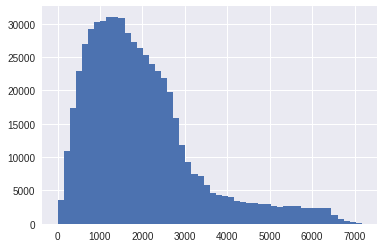

In [14]:
plt.hist(df_trees["Horizontal_Distance_To_Fire_Points"],50);

In [15]:
df_trees["Horizontal_Distance_To_Fire_Points"][df_trees["Horizontal_Distance_To_Fire_Points"]<1000].count()/df_trees["Cover_Type"].count()

0.24182116720480817

### High risk areas

We take point closer than 600 m (~10% of the entries) to wildfires as high risk zones.

In [16]:
df_high = pd.read_csv("Trees_clean.csv")
df_high["Horizontal_Distance_To_Fire_Points"].max()

7173

In [17]:
df_high["Horizontal_Distance_To_Fire_Points"].replace(np.arange(0,601,1),1, inplace=True)
df_high["Horizontal_Distance_To_Fire_Points"].replace(np.arange(601,8000,1),0, inplace=True)

In [18]:
df_high["Horizontal_Distance_To_Fire_Points"][df_high["Horizontal_Distance_To_Fire_Points"]==1].count()/(df_high["Horizontal_Distance_To_Fire_Points"].count())

0.10188429843101347

In [19]:
Counter(df_high["Horizontal_Distance_To_Fire_Points"])

Counter({0: 521816, 1: 59196})

In [20]:
df_high.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
0,2596,51,3,258,0,510,221,232,148,0,5,29
1,2590,56,2,212,-6,390,220,235,151,0,5,29
2,2804,139,9,268,65,3180,234,238,135,0,2,12
3,2785,155,18,242,118,3090,238,238,122,0,2,30
4,2595,45,2,153,-1,391,220,234,150,0,5,29


In [21]:
df_high.to_csv("Fire_high.csv",index=False)

### Fire risk scale

We classify the risk for fire as:

Closer than 600 m (~10% of the entries) to wildfires as high risk zones (Label = 2).  
Between 601 m and 1700 m (~40% of the entries) to wildfires as moderate risk zones (Label = 1).  
Further away than 1700 m (~50% of the entries) to wildfires as low risk zones (Label = 0).  

In [22]:
df_multi = pd.read_csv("Trees_clean.csv")
df_multi["Horizontal_Distance_To_Fire_Points"].replace(np.arange(0,601,1),2, inplace=True)
df_multi["Horizontal_Distance_To_Fire_Points"].replace(np.arange(601,1701,1),1, inplace=True)
df_multi["Horizontal_Distance_To_Fire_Points"].replace(np.arange(1701,8000,1),0, inplace=True)

In [23]:
df_multi["Horizontal_Distance_To_Fire_Points"][df_multi["Horizontal_Distance_To_Fire_Points"]==1].count()/(df_multi["Horizontal_Distance_To_Fire_Points"].count())

0.3950159377086876

In [24]:
Counter(df_multi["Horizontal_Distance_To_Fire_Points"])

Counter({0: 292307, 1: 229509, 2: 59196})

In [25]:
df_multi.to_csv("Fire_multi.csv",index=False)

In [33]:
X = df_multi.drop("Horizontal_Distance_To_Fire_Points", axis=1)
y = df_multi["Horizontal_Distance_To_Fire_Points"]

In [34]:
X["Vertical_Distance_To_Hydrology"] = X["Vertical_Distance_To_Hydrology"] + 173

In [37]:
sca = StandardScaler()
sca.fit_transform(X);

In [38]:
chi2(X,y)

(array([9.16052147e+05, 5.68018071e+05, 7.05268306e+04, 1.00187658e+06,
        3.31147835e+04, 3.62313072e+07, 3.69023090e+04, 2.32536686e+03,
        2.15522723e+04, 7.48371337e+03, 6.94224934e+04]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [32]:
X.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Cover_Type',
       'Soil_Type'],
      dtype='object')